In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import seaborn as sns
sns.set_style('white', {'font.family':'sans-serif'})
sns.set_context('paper', font_scale=1.4)
sns.set_palette("cubehelix", 8)

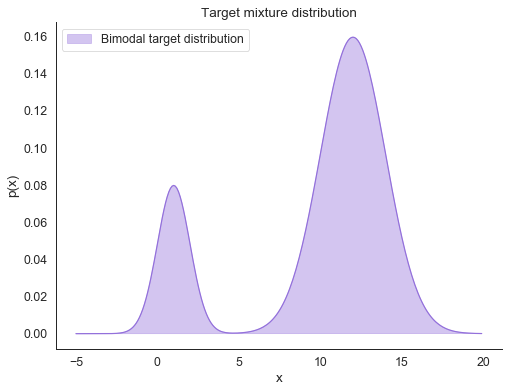

In [3]:
class GaussianMixtureModel:
    def __init__(self, mu, sigma, weights):
        self.weights = np.atleast_1d(weights)
        self.weights /= self.weights.sum()
        self.mu = np.atleast_1d(mu)
        self.sigma = np.atleast_1d(sigma)        
        self.K = len(self.weights)        
        assert self.K == len(self.mu)
        assert self.K == len(self.sigma)
            
    def marginal(self, x):
        '''Marginal likelihood of mixture model'''
        return np.asarray([self.weights[i] * stats.norm.pdf(x, self.mu[i], self.sigma[i]) 
                           for i in range(self.K)]).sum(0)
    
    def sample(self, n, return_z=False):
        z = np.random.choice(self.K, p=self.weights, size=n)
        xz = np.array([stats.norm.rvs(self.mu[i], self.sigma[i], size=n) for i in range(self.K)])
        y = xz[z, range(n)]
        if return_z:
            return y, z
        else:
            return y
    
class EmpiricalDistribution:
    def __init__(self, true_dist, n):
        self.samples = true_dist.sample(n)
        
    def sample(self, n):
        return np.random.choice(self.samples, size=n)
    
    def marginal(self, x):
        return np.full(len(x), 1/len(self.samples))
        
nsamples = 1000
p_bimodal = GaussianMixtureModel(mu=[1.0, 12.0], sigma=[1.0, 2.0], weights=[0.2, 0.8])

plt.figure(figsize=(8,6))
plt.title('Target mixture distribution')
x = np.arange(-5, 20, 0.1)
plt.fill(x, p_bimodal.marginal(x), label='Bimodal target distribution', alpha=0.4, color='mediumpurple')
plt.plot(x, p_bimodal.marginal(x), color='mediumpurple')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
sns.despine()

In [4]:
def r_to_sigma2(r):
    return np.exp(r)

def sigma2_to_r(sigma2):
    return np.log(sigma2)

def log_q(x, mu, sigma2):
    return stats.norm.logpdf(x, mu, np.sqrt(sigma2))

def sample_q(n, mu, sigma2):
    return stats.norm.rvs(mu, np.sqrt(sigma2), size=n)    

def grad_log_q(x, mu, r):
    d = x - mu
    grad_mu = d * np.exp(-r)
    grad_r = -0.5 + 0.5*(d**2)*np.exp(-r)
    return np.array([grad_mu, grad_r])

In [5]:
def minimize_kl_pq(p, mu, sigma2, batch_size=50, epochs=100, alpha=(1e-3, 1e-3), verbose=False):
    r = sigma2_to_r(sigma2) # reparametrization
    
    for e in range(epochs):        
        x = p.sample(batch_size)        
        grad = -grad_log_q(x, mu, r).mean(1)
        mu -= alpha[0]*grad[0]
        r -= alpha[1]*grad[1]
        if verbose and e % (epochs//10) == 0:
            print(e, -log_q(x, mu, r).mean())       
    return mu, r_to_sigma2(r)

def minimize_kl_qp(p, mu, sigma2, batch_size=50, epochs=100, alpha=(1e-3, 1e-3), verbose=False):
    r = sigma2_to_r(sigma2) # reparametrization
    
    for e in range(epochs):
        x = sample_q(batch_size, mu, r_to_sigma2(r))
        lq = log_q(x, mu, r_to_sigma2(r))
        lp = np.log(p.marginal(x))
        grads = grad_log_q(x, mu, r)
        grad = (grads * (lq - lp + 1)).mean(1)
        mu -= alpha[0]*grad[0]
        r -= alpha[1]*grad[1]
        if verbose and e % (epochs//10) == 0:
            print(e, -log_q(x, mu, r).mean())
    return mu, r_to_sigma2(r)

def minimize_kl_pq_closedform(p, *args, batch_size=50, epochs=100, **kwargs):
    samples = p.sample(batch_size*epochs)
    mu = samples.mean()
    sigma2 = ((samples - mu)**2).mean()
    return mu, sigma2
    

In [6]:
def minimize_and_plot(p, title, theta_start=(6,3), use_empirical=False, **kwargs):    
    if use_empirical:
        p_emp = EmpiricalDistribution(p, kwargs.pop('nsamples_emp', 100))
    else:
        p_emp = p
        
    theta_final_pq = minimize_kl_pq(p_emp, *theta_start, **kwargs)    
    theta_final_qp = minimize_kl_qp(p, *theta_start, **kwargs)
    theta_final_pq_closed = minimize_kl_pq_closedform(p, *theta_start, **kwargs)

    def plot_start_and_target(ax, x, p, theta):
        ax.fill(x, p.marginal(x), label='Target marginal likelihood', alpha=0.4, color='mediumpurple')
        ax.plot(x, p.marginal(x), label='Target marginal likelihood', color='mediumpurple')
        ax.plot(x, np.exp(log_q(x, *theta)), '--', label='Initial Condition', color='gray')

    x = np.arange(-5, 20, 0.1)
    fig, axs = plt.subplots(1, 2, figsize=(15,6), sharey=True, sharex=True)
    fig.suptitle(f'{title}')
    
    plot_start_and_target(axs[0], x, p, theta_start)
    axs[0].plot(x, np.exp(log_q(x, *theta_final_pq)), label=r'Result KL$(p|q)$ stochastic', color='black')
    axs[0].plot(x, np.exp(log_q(x, *theta_final_pq_closed)), '-', label=r'Result KL$(p|q)$ closed-form', color='green')
    axs[0].set_title('Density Estimation KL$(p|q)$')
    axs[0].set_ylabel('p(x)')
    axs[0].set_xlabel('x')
    axs[0].legend()
    
    plot_start_and_target(axs[1], x, p, theta_start)
    axs[1].plot(x, np.exp(log_q(x, *theta_final_qp)), label=r'Result KL$(q|p)$ stochastic', color='black')
    axs[1].set_title('Density Estimation KL$(q|p)$')
    axs[1].set_ylabel('p(x)')
    axs[1].set_xlabel('x')
    axs[1].legend()
    
    plt.tight_layout()
    sns.despine()
    plt.savefig(f'figures/{title.replace(" ", "_")}.png', dpi=200)
    plt.show()

## Bimodal target distribution

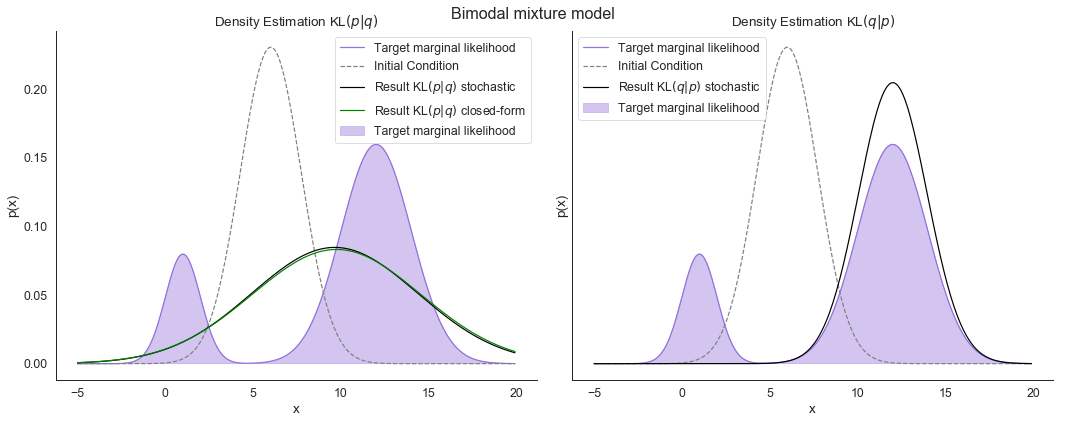

In [7]:
params = dict(epochs=1200, alpha=(1e-1, 1e-1), batch_size=10)
minimize_and_plot(p_bimodal, 'Bimodal mixture model', use_empirical=True, **params)

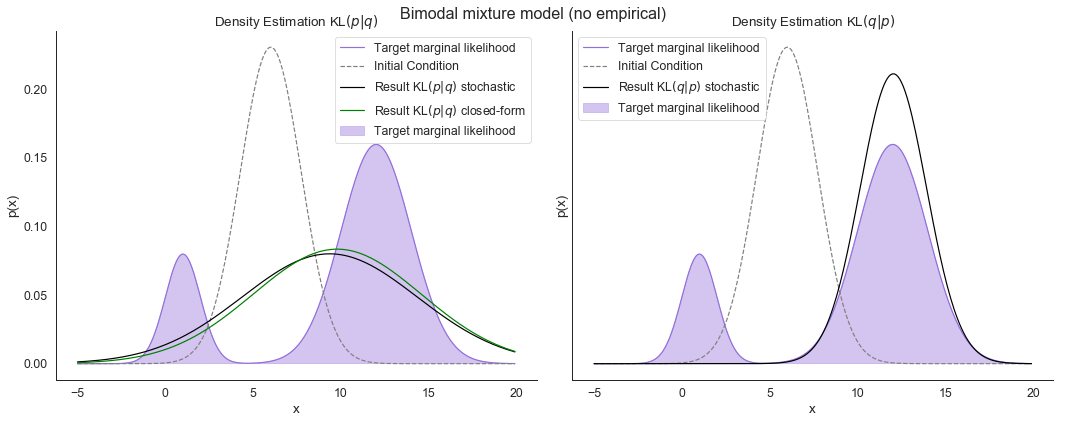

In [8]:
params = dict(epochs=500, alpha=(1e-1, 1e-1), batch_size=10)
minimize_and_plot(p_bimodal, 'Bimodal mixture model (no empirical)', use_empirical=False, **params)

## Unimodal target distribution

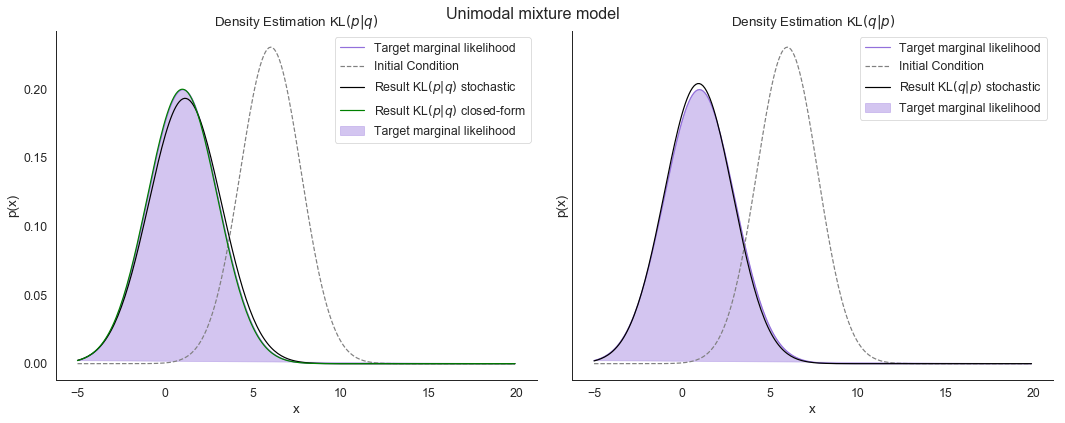

In [9]:
p_unimodal = GaussianMixtureModel(mu=[1.0], sigma=[2.0], weights=[1.0])
params = dict(epochs=800, alpha=(1e-1, 1e-1), batch_size=10)
minimize_and_plot(p_unimodal, 'Unimodal mixture model', use_empirical=True, **params)

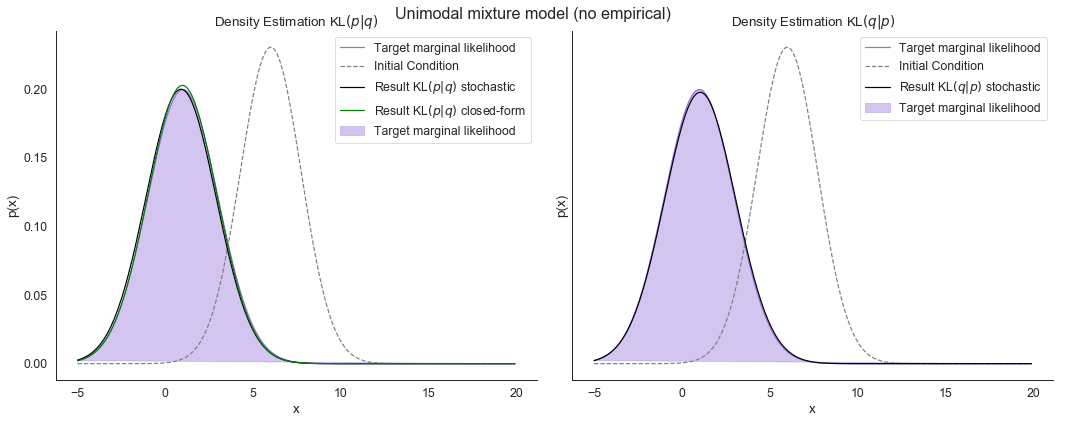

In [10]:
params = dict(epochs=800, alpha=(1e-1, 1e-1), batch_size=10)
minimize_and_plot(p_unimodal, 'Unimodal mixture model (no empirical)', use_empirical=False, **params)

### Expectation Maximization

In [11]:
# theta = (u1, u2, rho, sigma)
theta_true = np.array([0., 6., 0.7, 1])

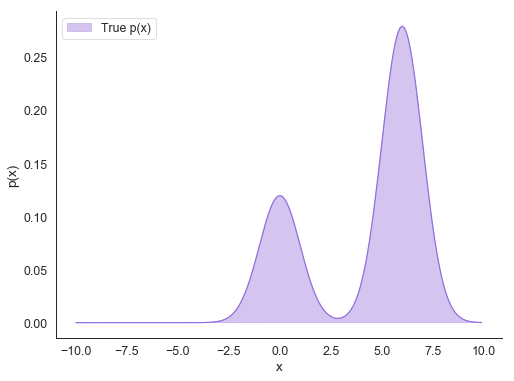

In [12]:
p_true = GaussianMixtureModel(mu=theta_true[:2], sigma=[theta_true[-1]]*2, weights=[1-theta_true[2], theta_true[2]])

plt.figure(figsize=(8,6))
x = np.arange(-10, 10, 0.1)
plt.fill(x, p_true.marginal(x), label='True p(x)', alpha=0.4, color='mediumpurple')
plt.plot(x, p_true.marginal(x), color='mediumpurple')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
sns.despine()

In [13]:
def sample_y(xh, theta, n):
    mu0, mu1, rho, sigma = theta
    # compute p(yh_i | xh_i, theta) for each observation.
    p_xy_cond_theta = np.empty((xh.shape[0], 2))
    p_xy_cond_theta[:, 0] = stats.norm.pdf(xh, loc=mu0, scale=sigma) * (1-rho)
    p_xy_cond_theta[:, 1] = stats.norm.pdf(xh, loc=mu1, scale=sigma) * rho
        
    p_y_cond_xtheta = p_xy_cond_theta / p_xy_cond_theta.sum(-1, keepdims=True)
    
    # Note this samples from the joint p(yh | xh, theta). Because of 
    # indep. assumptions each p(yh_i|xh_i, theta) is indep, therefore we
    # simply sample from each separately n times. A single sample is considered
    # yh = (yh_0 ... yh_m)
    return np.random.binomial(1, p_y_cond_xtheta[:,1], size=(n, xh.shape[0]))

In [14]:
def grad_mu(x, y, theta):
    mu = theta[:2]
    sigma = theta[-1]
        
    d = ((x[None, :] - mu.take(y)) / sigma).reshape(-1)
    return d[y.reshape(-1) == 0], d[y.reshape(-1) == 1]    

def grad_rho(y, theta):
    rho = theta[2]    
    k = (1-rho)*rho
    return (y.reshape(-1) - rho) / k

def grad_log_joint(xo, yo, xh, yh, theta):
    
    g_mu_h = grad_mu(xh, yh, theta)
    g_mu_o = grad_mu(xo, yo, theta)
      
    g_mu0 = np.concatenate((g_mu_h[0], g_mu_o[0])).mean()
    g_mu1 = np.concatenate((g_mu_h[1], g_mu_o[1])).mean()
    
    g_rho_h = grad_rho(yh, theta) 
    g_rho_o = grad_rho(yo, theta)
    g_rho = np.concatenate((g_rho_h, g_rho_o)).mean()
    
    return np.array([g_mu0, g_mu1, g_rho])



    
def optimize_sgd(xo, yo, xh, theta, epochs=100, batchsize=10, alpha=(1e-2, 1e-2, 1e-2), momentum=0.9):
    alpha = np.asarray(alpha)
    last_grad = 0
    for e in range(epochs):
        yh = sample_y(xh, theta, batchsize) # yh is B x xh.shape[0]
        grad = grad_log_joint(xo, yo, xh, yh, theta)
        last_grad = momentum * last_grad + (1-momentum) * grad        
        theta[:3] += alpha * last_grad
        if e % (epochs//10) == 0:
            print(e, theta)
            
    return theta

def mle_log_joint(xo, yo, xh, yh):
    
    #xo = np.tile(xo.reshape(1, -1), (yo.shape[0], 1)).reshape(-1)
    xh = np.tile(xh.reshape(1, -1), (yh.shape[0], 1)).reshape(-1)
    
    
    x = np.concatenate((xo, xh))
    y = np.concatenate((yo.reshape(-1), yh.reshape(-1)))
       
    m = (y == 0)
    mu0_mle = x[m].mean()
    mu1_mle = x[~m].mean()    
    rho_mle = np.sum(y) / y.shape[0]
    
    return np.array([mu0_mle, mu1_mle, rho_mle])


def optimize_mle(xo, yo, xh, theta, epochs=100, batchsize=10):
    for e in range(epochs):
        yh = sample_y(xh, theta, batchsize) # yh is B x xh.shape[0]
        theta[:3] = mle_log_joint(xo, yo, xh, yh)        
        if e % (epochs//10) == 0:
            print(e, theta)
            
    return theta

In [15]:
x_true, y_true = p_true.sample(200, return_z=True)

nobs = 40
xo, yo = x_true[:nobs], y_true[:nobs]
xh = x_true[nobs:]

theta_start = np.array([-8, -2, 0.9, 1])
theta_opt = optimize_sgd(xo, yo, xh, theta_start.copy(), alpha=(1e-2, 1e-2, 1e-3), epochs=1000, batchsize=60, momentum=0.95)

0 [-7.9958434  -1.99693771  0.90005492  1.        ]
100 [-3.40797144  1.8044431   0.98008276  1.        ]
200 [-1.73994166  3.95663819  0.88233357  1.        ]
300 [-0.71086888  5.12502621  0.80267935  1.        ]
400 [-0.25838526  5.59744099  0.76071737  1.        ]
500 [-0.1105097   5.74189971  0.73937053  1.        ]
600 [-0.06696173  5.78244003  0.72791867  1.        ]
700 [-0.05430743  5.79359643  0.72154864  1.        ]
800 [-0.0510905   5.79649895  0.71796769  1.        ]
900 [-0.04978343  5.79752023  0.71589388  1.        ]


In [16]:
theta_opt_mle = optimize_mle(xo, yo, xh, theta_start.copy(), epochs=10, batchsize=60)

0 [0.31319655 4.12458693 0.99885892 1.        ]
1 [-0.62034523  5.22429228  0.81109959  1.        ]
2 [-0.11321355  5.75541908  0.72136929  1.        ]
3 [-0.0484228   5.79849827  0.7129668   1.        ]
4 [-0.05088375  5.7969365   0.71327801  1.        ]
5 [-0.0484228   5.79849827  0.7129668   1.        ]
6 [-0.0497358   5.79732541  0.71317427  1.        ]
7 [-0.04969229  5.79815851  0.71307054  1.        ]
8 [-0.04801413  5.79833374  0.7129668   1.        ]
9 [-0.05467314  5.79505677  0.71369295  1.        ]


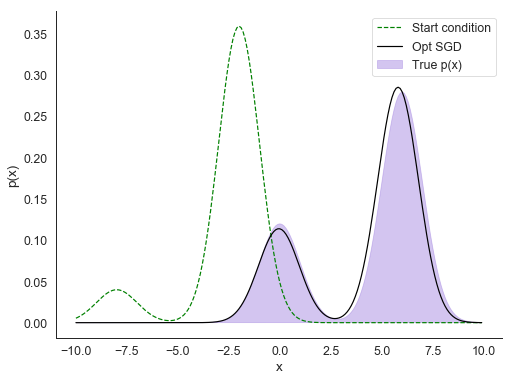

In [17]:
def make_mixture(theta):
    return GaussianMixtureModel(mu=theta[:2], sigma=[theta[-1]]*2, weights=[1-theta[2], theta[2]])

p_start = make_mixture(theta_start)
p_opt = make_mixture(theta_opt)

plt.figure(figsize=(8,6))
x = np.arange(-10, 10, 0.1)
plt.fill(x, p_true.marginal(x), label='True p(x)', alpha=0.4, color='mediumpurple')
plt.plot(x, p_start.marginal(x), '--', label='Start condition', color='green')
plt.plot(x, p_opt.marginal(x), label='Opt SGD', color='black')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
sns.despine()

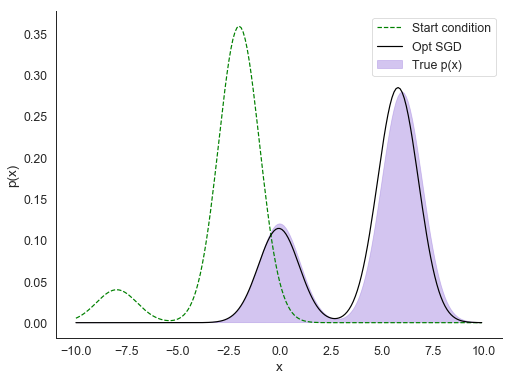

In [18]:
p_opt = make_mixture(theta_opt_mle)

plt.figure(figsize=(8,6))
x = np.arange(-10, 10, 0.1)
plt.fill(x, p_true.marginal(x), label='True p(x)', alpha=0.4, color='mediumpurple')
plt.plot(x, p_start.marginal(x), '--', label='Start condition', color='green')
plt.plot(x, p_opt.marginal(x), label='Opt SGD', color='black')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
sns.despine()